# AutoEncoders

In this notebook we investigate AutoEncoders and take a deeper look at what neural networks learn.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/AutoEncoders.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/AutoEncoders.ipynb)

In [13]:
# @title setup and imports

import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.mnist import MNIST
from torchvision.datasets.cifar import CIFAR10

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [35]:
# @title plotting functions

def plot_history(history):
    if 'train_acc' in history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(history['train_loss'], label='train')
        ax1.plot(history['test_loss'], label='test')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(history['train_acc'], label='train')
        ax2.plot(history['test_acc'], label='test')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        plt.plot(history['train_loss'], label='train')
        plt.plot(history['test_loss'], label='test')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    plt.show()


def plot_conf_mat(model, dataloader, device=device):
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


def visualize(embedded, labels, title=''):
    fig, ax = plt.subplots(figsize=(12,8))

    # get discrete colormap
    cmap = plt.get_cmap('jet', 10) # virdis

    # plot scatter points
    scatter = ax.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap=cmap)

    # add colorbar
    cbar = plt.colorbar(scatter)

    # set ticks locations
    cbar.set_ticks((np.arange(10) + 0.5) * (10 - 1) / 10)

    # set tick labels
    cbar.set_ticklabels([str(i) for i in range(10)])

    plt.title(title)
    plt.show()


def plot_last_hidden_layer(model, dataloader, method='PCA'):
    with torch.no_grad():
        encoded_data, labels = [], []
        for imgs, lbls in dataloader:
            encoded = model.last_hidden_layer(imgs.to(device))
            encoded_data.append(encoded.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    # Concatenate the encoded representations and labels
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'PCA':
        embedded = PCA(n_components=2).fit_transform(encoded_data)
        title = 'Reduction of the Last Hidden Layer using PCA'
    else:
        embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                        perplexity=3).fit_transform(encoded_data)
        title = 'Reduction of the Last Hidden Layer using t-SNE'

    visualize(embedded, labels, title)


def plot_autoencoder(model, dataloader, method='PCA', denoising=False):
    with torch.no_grad():
        encoded_data, labels = [], []
        for imgs, lbls in dataloader:
            encoded = model.encoder(imgs.to(device))
            if denoising:
                encoded = encoded.view(encoded.size(0), -1)
            encoded_data.append(encoded.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    # Concatenate the encoded representations and labels
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    if encoded_data.shape[1] == 2:
        embedded = encoded_data
        title = 'Latent Space'
    elif method == 'PCA':
        embedded = PCA(n_components=2).fit_transform(encoded_data)
        title = 'Reduction of the Latent Space using PCA'
    else:
        embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                        perplexity=3).fit_transform(encoded_data)
        title = 'Reduction of the Latent Space using t-SNE'

    visualize(embedded, labels, title)



def plot_reconstruction(model, dataset, denoising=False, mask= False):
    # Choose 10 random samples
    random_indices = np.random.choice(len(dataset), size=10, replace=False)

    # Get images and labels for the chosen samples
    images = [dataset[i][0] for i in random_indices]
    labels = [dataset[i][1] for i in random_indices]

    is_grayscale = images[0].shape[0]==1
    cmap = 'gray' if is_grayscale else None

    if denoising:
        noisy_images = [add_noise(image, mask=mask) for image in images]

    # Reconstruct the images using the autoencoder
    with torch.no_grad():
        if denoising:
            reconstructed_images = [model(noisy_image.unsqueeze(0).to(device)).squeeze().cpu() for noisy_image in noisy_images]
        else:
            reconstructed_images = [model(image.unsqueeze(0).to(device)).squeeze().cpu() for image in images]

    if denoising:
        # Display the original and reconstructed images
        fig, axes = plt.subplots(3, 10, figsize=(15, 5))

        # First row: Original images
        for i, image in enumerate(images):
            if is_grayscale:
                axes[0, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:
                axes[0, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[0, i].set_title(f"Original {labels[i]}")
            axes[0, i].axis('off')

        # Second row: Noisy images
        for i, image in enumerate(noisy_images):
            if is_grayscale:
                axes[1, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:

                axes[1, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[1, i].set_title(f"Noisy {labels[i]}")
            axes[1, i].axis('off')

        # Third row: Reconstructed images
        for i, image in enumerate(reconstructed_images):
            if is_grayscale:
                axes[2, i].imshow(image.squeeze().numpy().reshape(28, 28), cmap=cmap)
            else:
                axes[2, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[2, i].set_title(f"Reconstructed")
            axes[2, i].axis('off')

    else:
        # Display the original and reconstructed images
        fig, axes = plt.subplots(2, 10, figsize=(15, 3))

        # First row: Original images
        for i, image in enumerate(images):
            if is_grayscale:
                axes[0, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:
                axes[0, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[0, i].set_title(f"Label: {labels[i]}")
            axes[0, i].axis('off')

        # Second row: Reconstructed images
        for i, image in enumerate(reconstructed_images):
            if is_grayscale:
                axes[1, i].imshow(image.detach().numpy().reshape(28, 28), cmap=cmap)
            else:
                axes[1, i].imshow(image.detach().numpy(), cmap=cmap)
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
# @title MNIST dataset

batch_size = 256

trainset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Neural Network

First we will try to train a simple neural network. Our goal is to visualize datapoints from the last hidden layer of this network, so we create the `last_hidden_layer` function to access the output of this layer.

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fe = nn.Sequential(nn.Linear(784, 256),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, 64),
                                nn.ReLU(inplace=True))
        self.fc = nn.Linear(64, 10)

    def last_hidden_layer(self, x):
        x = torch.flatten(x, start_dim=1) / 255.
        return self.fe(x)

    def forward(self, x):
        out = self.last_hidden_layer(x)
        out = self.fc(out)
        return out

In [5]:
# @title neural netwrok helper functions

def classifier_train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc


def classifier_test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.
    test_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            test_acc += (logits.argmax(dim=1) == labels).sum().item()
        test_loss /= len(dataloader)
        test_acc /= len(dataloader.dataset)
    return test_loss, test_acc


def train_classifier(model, train_dataloader, test_dataloader, n_epochs, device=device):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    optimizer = Adam(model.parameters())
    loss_fn = CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = classifier_train_step(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        test_loss, test_acc = classifier_test_step(model, test_dataloader, loss_fn, device)
        history['test_loss'].append(test_loss), history['test_acc'].append(test_acc)
        pbar.set_description(f'Training Accuracy {100 * train_acc:.2f}% | Test Accuracy {100 * test_acc:.2f}% ')
    return history

Training Accuracy 95.04% | Test Accuracy 94.84% : 100%|██████████| 30/30 [07:23<00:00, 14.79s/it]


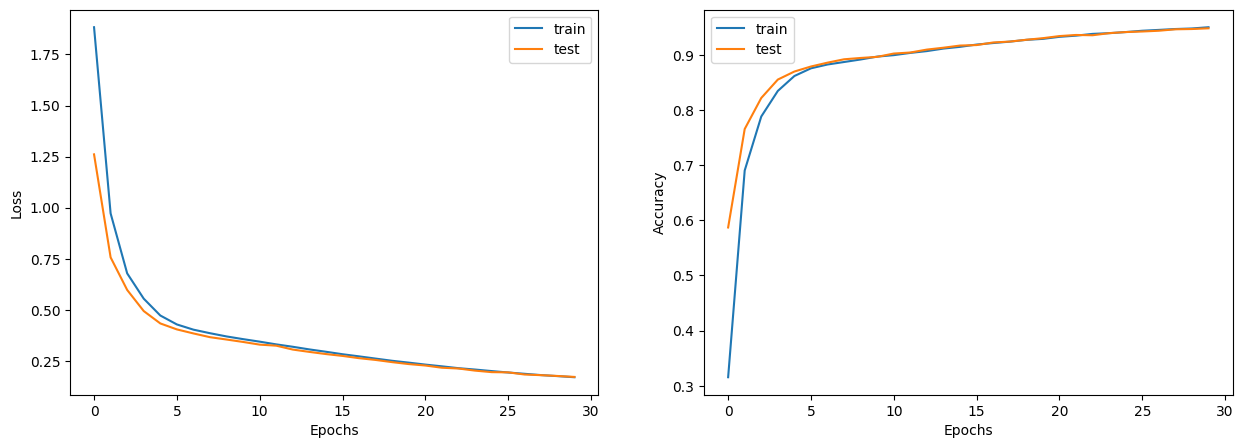

In [6]:
net = Network().to(device)

results = train_classifier(net, trainloader, testloader, n_epochs=30)
plot_history(results)

To get a better sense of our training, we plot the confusion matrix for the test dataset.

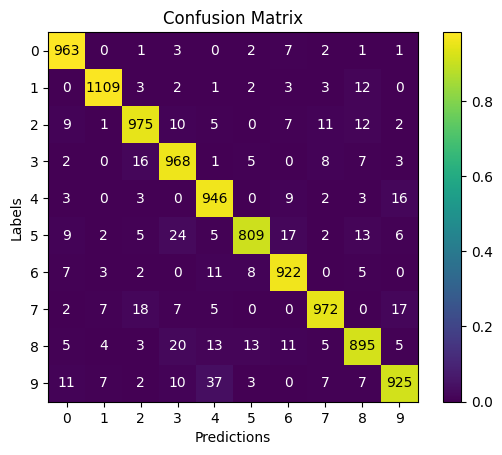

In [7]:
plot_conf_mat(net, testloader)

If we pass all the images from the test dataset to network and obtain the output of the last hidden layer (the input of the final layer) and perform PCA on it here is what we see:

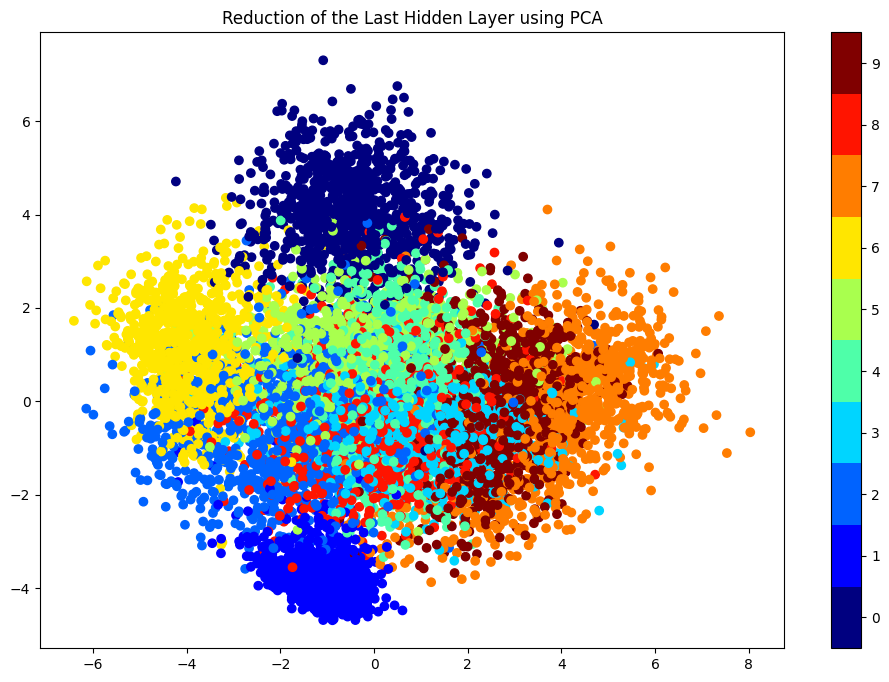

In [8]:
plot_last_hidden_layer(net, testloader, method='PCA')

If we pass all the images from the test dataset to network and obtain the output of the last hidden layer (the input of the final layer) and perform t-SNE on it here is what we see:

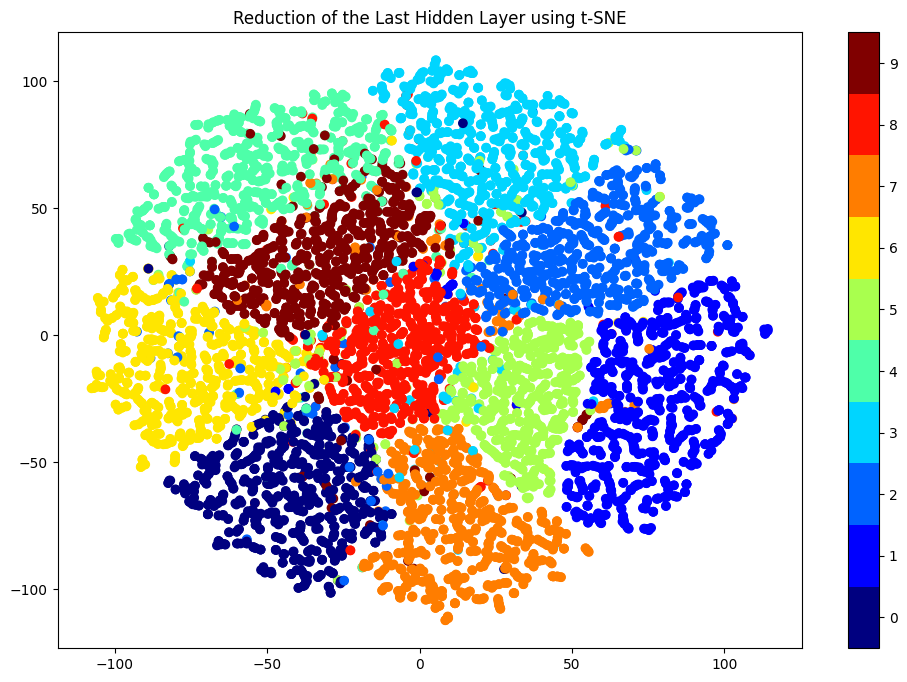

In [9]:
plot_last_hidden_layer(net, testloader, method='t-SNE')

Keep in mind in order to have high accuracy, the last hidden layer must make datapoints from different classees linearly separable.

# AutoEncoder

In this section we first create an AutoEncoder. An AutoEncoder has two networks, the encoder network which reduces the dimensionality of the data into its latent space representation, and the decoder network which increases the dimensionality and reconstructs the input from the latent space representation.

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # The Encoder Network
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(28 * 28, 256),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(256, 64),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(64, 16),)
        # The Decoder Network
        self.decoder = nn.Sequential(nn.Linear(16, 64),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(64, 256),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(256, 28 * 28),
                                     nn.Unflatten(1, (1, 28, 28)),
                                     nn.Sigmoid())

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return out

In [14]:
# @title AutoEncoder helper functions
def mask_image(x, square_size=5, number_of_squares=3):
    masked = x.clone()
    for _ in range(number_of_squares):
        start_i = torch.randint(0, x.shape[-2]-square_size, (1, ))
        start_j = torch.randint(0, x.shape[-1]-square_size, (1, ))
        masked[..., start_i:start_i+square_size, start_j:start_j+square_size]=0
    return masked

def add_noise(x, mask= False):
    if mask:
        return mask_image(x)

    select_mode = np.random.uniform()

    if select_mode <= 1/6: # gaussian noise
        noisy = x + torch.randn_like(x) * 0.5

    elif select_mode <= 2/6: # salt and pepper noise
        noise = torch.rand_like(x)
        noisy = x.clone()
        noisy[noise < 0.1] = 0
        noisy[noise > 0.9] = 1

    elif select_mode <= 3/6: # speckle noise
        noisy = x + x*torch.randn_like(x)

    elif select_mode <= 4/6: # poisson
        noisy = torch.poisson(x * 2)/2

    elif select_mode <= 5/6: # square masking
        noisy = mask_image(x, square_size=4, number_of_squares=4)

    else: # bluring
        noisy = transforms.GaussianBlur(5, sigma=(2,2))(x)

    noisy[noisy < 0] = 0
    noisy[noisy > 1] = 1
    return noisy

def autoencoder_train_step(model, dataloader, loss_fn, optimizer, denoising, mask, device):
    model.train()
    train_loss = 0.
    for images, _ in dataloader:
        images = images.to(device)
        if denoising: # Add noise to the images
            noisy_images = add_noise(images, mask= mask)
            recons = model(noisy_images)
        else:
            recons = model(images)
        loss = loss_fn(recons, images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(dataloader)
    return train_loss


def autoencoder_test_step(model, dataloader, loss_fn, denoising, mask, device):
    model.eval()
    test_loss = 0.
    with torch.inference_mode():
        for images, _ in dataloader:
            images = images.to(device)
            if denoising: # Add noise to the images
                noisy_images = add_noise(images, mask=mask)
                recons = model(noisy_images)
            else:
                recons = model(images)
            loss = loss_fn(recons, images)
            test_loss += loss.item()
        test_loss /= len(dataloader)
    return test_loss


def train_autoencoder(model, train_dataloader, test_dataloader, n_epochs, denoising=False, mask=False, device=device):
    history = {'train_loss': [], 'test_loss': []}
    optimizer = Adam(model.parameters())
    loss_fn = nn.MSELoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss = autoencoder_train_step(model, train_dataloader, loss_fn, optimizer, denoising, mask, device)
        history['train_loss'].append(train_loss)
        test_loss = autoencoder_test_step(model, test_dataloader, loss_fn, denoising, mask, device)
        history['test_loss'].append(test_loss)
        pbar.set_description(f'Training Loss {train_loss:.3f} | Test Loss {test_loss:.3f} ')
    return history


Using the Mean Squared Error loss we can train the AutoEncoder to reconstruct images after encoding them using the encoder network and decoding the encoded representation.

Training Loss 0.011 | Test Loss 0.011 : 100%|██████████| 30/30 [04:00<00:00,  8.01s/it]


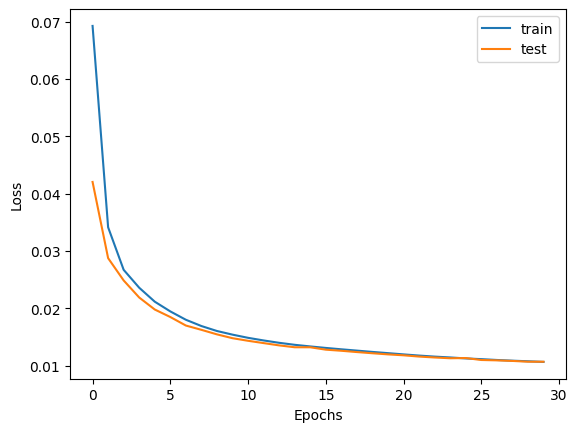

In [18]:
autoencoder = AutoEncoder().to(device)

res = train_autoencoder(autoencoder, trainloader, testloader, n_epochs=30)
plot_history(res)

We can reconstruct images from the training dataset:

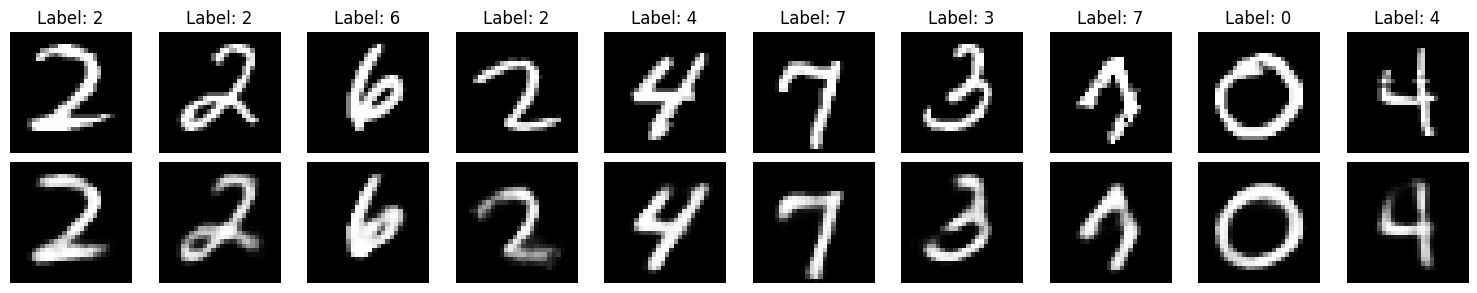

In [19]:
plot_reconstruction(autoencoder, trainset)

Or we can reconstruct images from the test dataset:

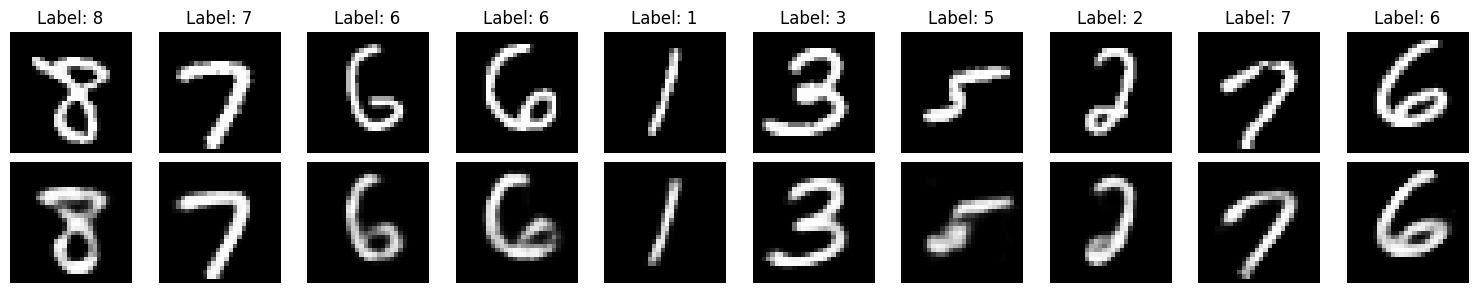

In [20]:
plot_reconstruction(autoencoder, testset)

## Latent Variable Space

While it would have been possible to encode the inputs into a two dimensional latent space, the reconstruction loss would not have been so easy to reduce. Therefore we can use PCA to reduce the latent space dimensions to two for visualization purposes:

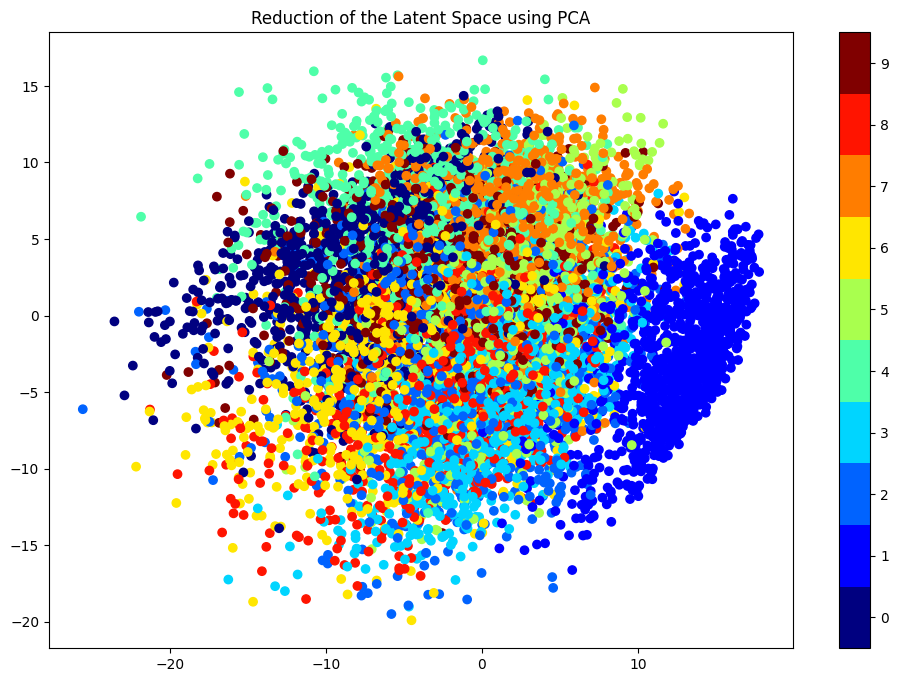

In [21]:
plot_autoencoder(autoencoder, testloader, method='PCA')

We can also use t-SNE:

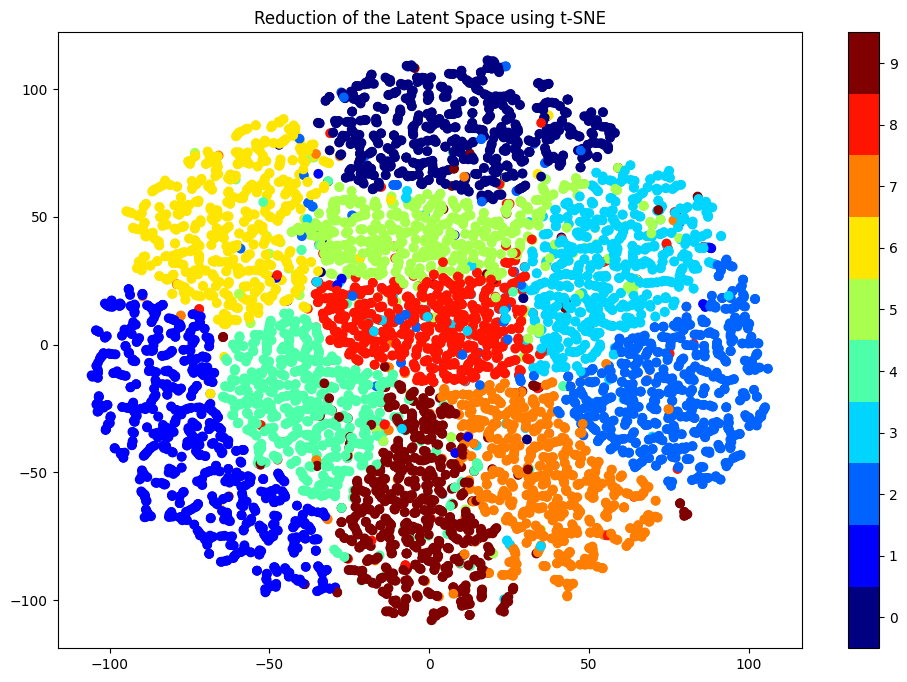

In [22]:
plot_autoencoder(autoencoder, testloader, method='t-SNE')

## Denoising

Another application of AutoEncoders is denoising. Even without training the AutoEncoder to denoise the inputs, we can obtain amazing results!

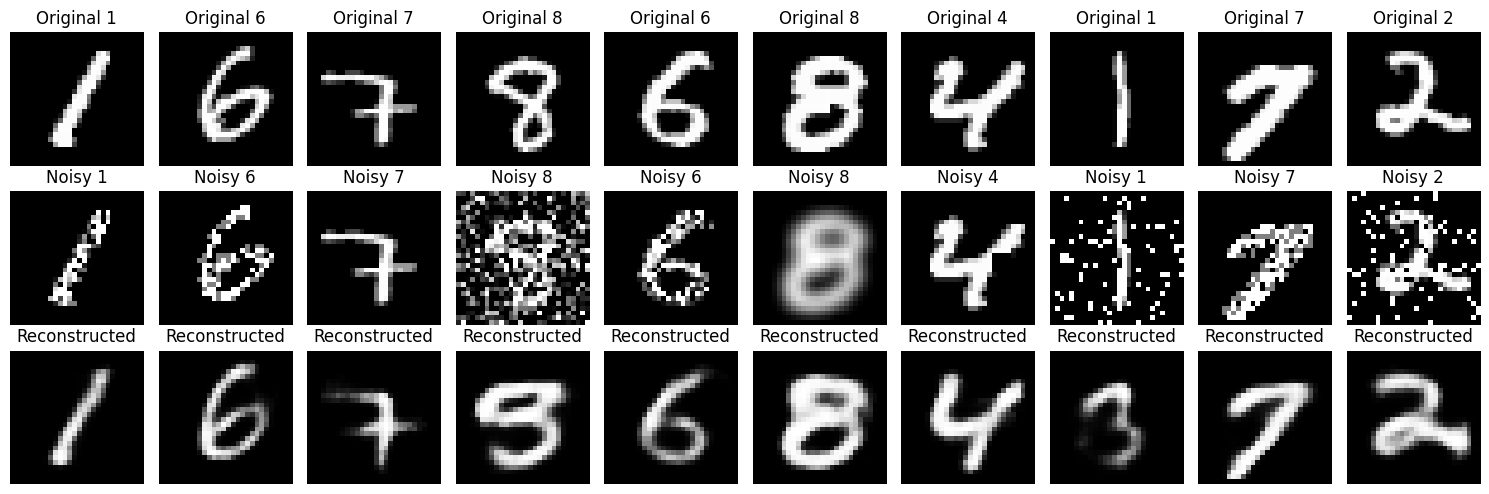

In [23]:
plot_reconstruction(autoencoder, testset, denoising=True)

## Denoising AutoEncoder

To make the model further robust to noises we can train an AutoEncoder with noisy data as input and the original data as desired output we can achieve a model that removes the noise from data! This type of AutoEncoders are called Denoising AutoEncoders.

Training Loss 0.017 | Test Loss 0.016 : 100%|██████████| 30/30 [03:55<00:00,  7.86s/it]


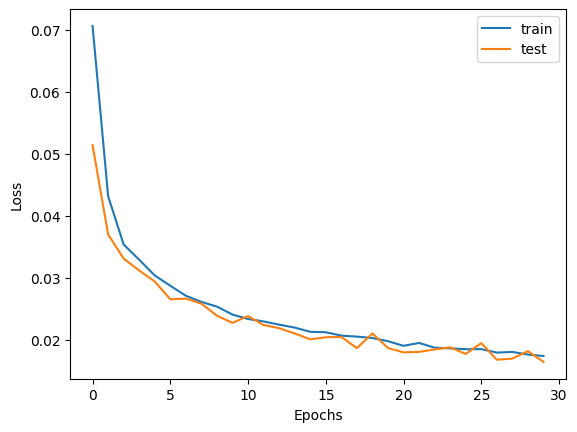

In [24]:
dae = AutoEncoder().to(device)

res = train_autoencoder(dae, trainloader, testloader, n_epochs=30, denoising=True)
plot_history(res)

We can compare the output of denoising autoencoder to normal autoencoder and see how much it has improved!

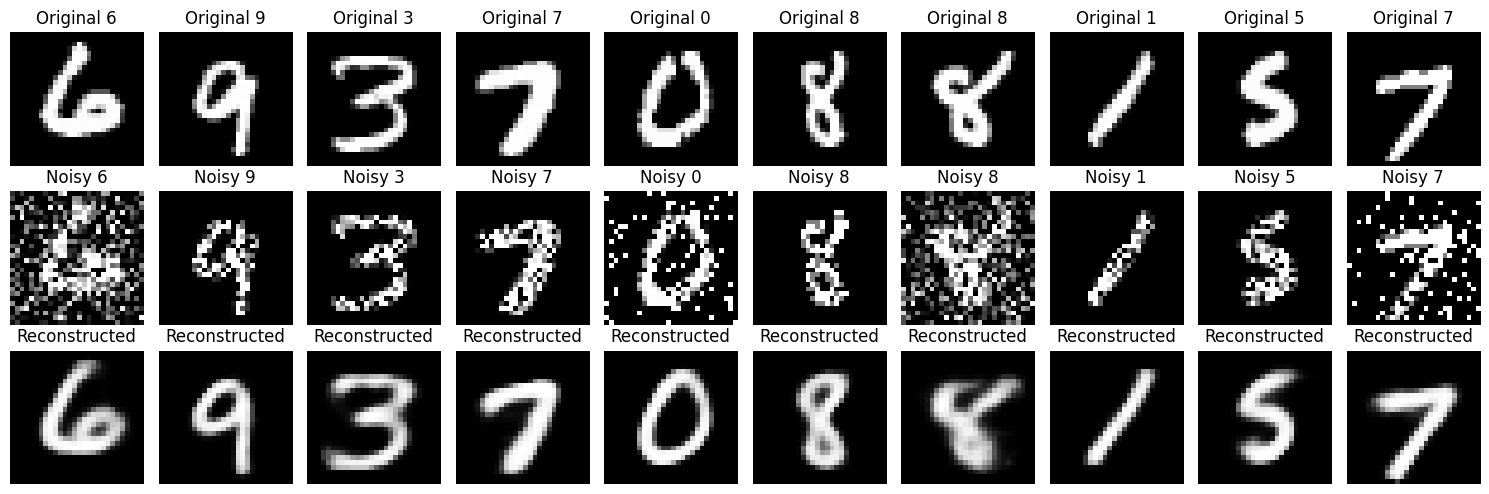

In [25]:
plot_reconstruction(dae, testset, denoising=True)

We can further apply idea of Denoising autoencoders to repair a damaged image. or to predict missing parts of an image. For this purpose we use CIFAR10, which is more general dataset, to train a model that predicts the masked parts of the image.

In [28]:
# @title CIFAR10 dataset
batch_size = 256

trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


in Denoising AutoEncoders latent feature dimensions doesn't have to be smaller, because the input and ouput are different, so there won't be a problem of learning the identity function without learning meaningful features. Since our data has become more complicated we need a more complex model.

In [10]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # The Encoder Network
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),  # (32x32x3) -> (16x16x64)
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # (16x16x64) -> (8x8x128)
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),  # (8x8x128) -> (4x4x256)
            nn.ReLU(True)
        )

        # The Decoder Network
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (4x4x256) -> (8x8x128)
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (8x8x128) -> (16x16x64)
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16x16x64) -> (32x32x3)
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return out

We then train our denoising autoencoder with masked data. That is some squares of each input image are set to zero randomly and in output we expect the model to predict the content behind those masks.

Training Loss 0.002 | Test Loss 0.002 : 100%|██████████| 30/30 [05:58<00:00, 11.97s/it]


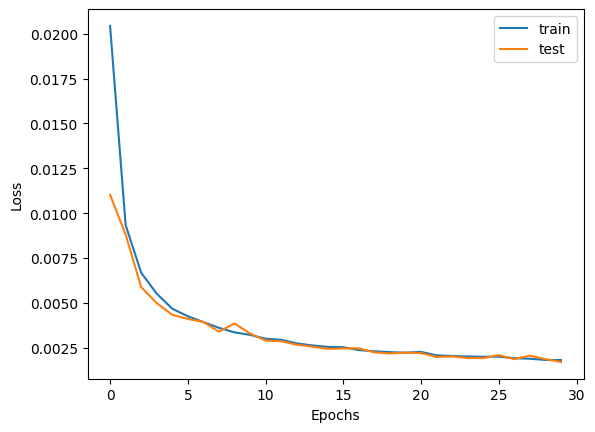

In [11]:
denoisingautoencoder = DenoisingAutoEncoder().to(device)

res = train_autoencoder(denoisingautoencoder, trainloader, testloader, n_epochs=30, denoising=True, mask= True)
plot_history(res)

By reconstructing the output of denoising autoencoder we see how model predicts the masked parts of unseen images!

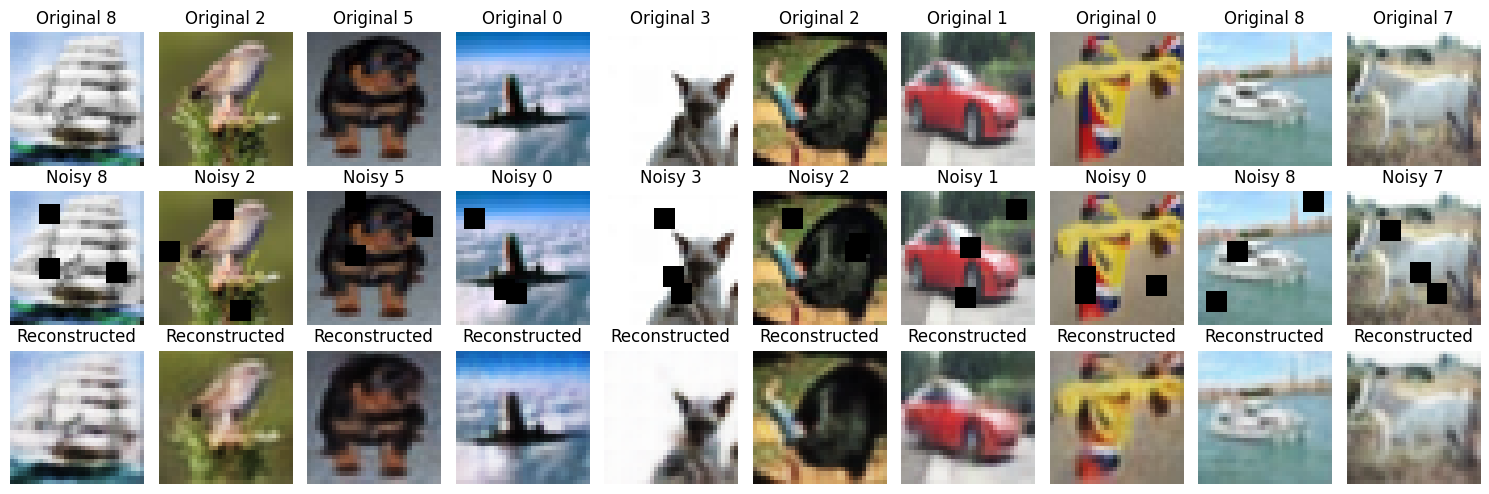

In [12]:
plot_reconstruction(denoisingautoencoder, testset, denoising=True, mask=True)